# Predictive Modeling

In [3]:
import pandas as pd
import os
import zipfile
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [4]:
# Extract the zip file
def extract_data(zip_file_path, extraction_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)

In [5]:
# Load datasets
def load_datasets(data_dir):
    valid_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.csv') and 'checkpoint' not in file:
                valid_files.append(os.path.join(root, file))
    datasets = {os.path.basename(file): pd.read_csv(file) for file in valid_files}
    return datasets

In [6]:
# Standardize key columns
def standardize_columns(datasets):
    for key, df in datasets.items():
        if 'city' in df.columns:
            df.rename(columns={'city': 'Metro_Area'}, inplace=True)
        if 'NAME' in df.columns:
            df.rename(columns={'NAME': 'Metro_Area'}, inplace=True)
        if 'Geographic Area' in df.columns:
            df.rename(columns={'Geographic Area': 'Metro_Area'}, inplace=True)
        if 'MSA' in df.columns:
            df.rename(columns={'MSA': 'Metro_Area'}, inplace=True)
        if 'year' in df.columns:
            df.rename(columns={'year': 'Year'}, inplace=True)
    return datasets

In [7]:
# Map Metro_Area_Code to Metro_Area
def map_metro_area_codes(datasets, code_to_area_mapping):
    if 'msa_unemployment.csv' in datasets:
        datasets['msa_unemployment.csv']['Metro_Area'] = datasets['msa_unemployment.csv']['Metro_Area_Code'].map(code_to_area_mapping)
    if 'msa_wages.csv' in datasets:
        datasets['msa_wages.csv']['Metro_Area'] = datasets['msa_wages.csv']['Metro_Area_Code'].map(code_to_area_mapping)
    return datasets

In [8]:
# Aggregate temporal data to yearly
def aggregate_to_yearly(datasets):
    for key, df in datasets.items():
        if 'DATE' in df.columns:
            df['Year'] = pd.to_datetime(df['DATE']).dt.year
            df.drop(columns=['DATE'], inplace=True)
        if 'Month of Period End' in df.columns:
            df['Year'] = pd.to_datetime(df['Month of Period End']).dt.year
            df.drop(columns=['Month of Period End'], inplace=True)
    return datasets

In [9]:
# Merge datasets
def merge_datasets(datasets, base_key):
    base_df = datasets[base_key]
    for key, df in datasets.items():
        if key != base_key:
            common_cols = set(['Metro_Area', 'Year']).intersection(df.columns)
            if common_cols:
                base_df = pd.merge(base_df, df, on=list(common_cols), how='left')
    return base_df


In [10]:
# Main execution
zip_file_path = '../data/preprocessed_data.zip'
extraction_dir = '../data/preprocessed_data/'
data_dir = os.path.join(extraction_dir, 'preprocessed_data')

# Extract data
extract_data(zip_file_path, extraction_dir)

# Load datasets
datasets = load_datasets(data_dir)

# Standardize columns
datasets = standardize_columns(datasets)

# Define a mapping for Metro_Area_Code (example mapping, extend as needed)
code_to_area_mapping = {
    'ATLA013URN': 'Atlanta-Sandy Springs-Roswell',
    'ENUC120640010SA': 'Atlanta-Sandy Springs-Roswell',
}

# Map Metro_Area_Code to Metro_Area
datasets = map_metro_area_codes(datasets, code_to_area_mapping)

# Aggregate data to yearly
datasets = aggregate_to_yearly(datasets)

# Merge datasets with cost burden as the base
base_df = merge_datasets(datasets, 'cost_burden_preprocessed.csv')

# Inspect the merged dataset
base_df_shape = base_df.shape
base_df_preview = base_df.head()

print(f"Merged dataset shape: {base_df_shape}")
print(base_df_preview)

Merged dataset shape: (360, 179)
                        Metro_Area  Year       A1        A2        A3  \
0          New York city, New York  2008  83720.0  593130.0  676850.0   
1          Camden city, New Jersey  2008   1960.0    7455.0    9415.0   
2     Jersey City city, New Jersey  2008   1445.0   15700.0   17145.0   
3          Newark city, New Jersey  2008   2715.0   26660.0   29375.0   
4  Philadelphia city, Pennsylvania  2008  59145.0  100900.0  160045.0   

        A4        A5        A6        A7        A8  ...  B07201_001E  \
0  93570.0  318565.0  412135.0  150230.0  361385.0  ...          NaN   
1   2115.0    3030.0    5145.0    2390.0    1945.0  ...          NaN   
2   2060.0    8590.0   10650.0    3855.0   10265.0  ...          NaN   
3   2875.0   13935.0   16810.0    3990.0   10715.0  ...          NaN   
4  44255.0   43115.0   87370.0   61930.0   47730.0  ...          NaN   

   POPULATION  Base Population (2020)  Population  GEOID  STATE_NAME  \
0         NaN          

In [11]:
# Step 1: Data Cleaning

# 1. Identify missing values in the dataset
missing_summary = base_df.isnull().mean().sort_values(ascending=False)

# Drop columns with more than 50% missing values
threshold = 0.5
columns_to_drop = missing_summary[missing_summary > threshold].index.tolist()
cleaned_df = base_df.drop(columns=columns_to_drop)

# 2. Remove non-predictive columns
# Identify potential non-predictive columns (e.g., identifiers, metadata)
non_predictive_columns = ['source_file', 'GEOID', 'STATE_NAME', 'Year_Permit_Type', 'Permit_Type']
cleaned_df = cleaned_df.drop(columns=[col for col in non_predictive_columns if col in cleaned_df.columns])

# 3. Simplify and normalize column names
cleaned_df.columns = (
    cleaned_df.columns.str.replace(" ", "_")
    .str.replace("-", "_")
    .str.replace("(", "")
    .str.replace(")", "")
    .str.lower()
)

# Display summary of changes and the cleaned dataset
cleaned_df_shape = cleaned_df.shape
cleaned_df_preview = cleaned_df.head()
cleaned_df_shape, cleaned_df_preview

((360, 131),
                         metro_area  year       a1        a2        a3  \
 0          New York city, New York  2008  83720.0  593130.0  676850.0   
 1          Camden city, New Jersey  2008   1960.0    7455.0    9415.0   
 2     Jersey City city, New Jersey  2008   1445.0   15700.0   17145.0   
 3          Newark city, New Jersey  2008   2715.0   26660.0   29375.0   
 4  Philadelphia city, Pennsylvania  2008  59145.0  100900.0  160045.0   
 
         a4        a5        a6        a7        a8  ...       j2       j4  \
 0  93570.0  318565.0  412135.0  150230.0  361385.0  ...  59335.0  69405.0   
 1   2115.0    3030.0    5145.0    2390.0    1945.0  ...   1305.0   1185.0   
 2   2060.0    8590.0   10650.0    3855.0   10265.0  ...   1235.0   1830.0   
 3   2875.0   13935.0   16810.0    3990.0   10715.0  ...   2235.0   2515.0   
 4  44255.0   43115.0   87370.0   61930.0   47730.0  ...  29985.0  21565.0   
 
         j5       j7       j8      j10      j11       j13      j14     

In [12]:
# Step 2: Feature Selection

# Identify columns that could be relevant to affordable housing shortages
# Group features into categories (affordability, supply-demand, economic factors, etc.)
affordability_features = [col for col in cleaned_df.columns if 'a' in col and col not in ['year', 'metro_area']]
supply_features = [col for col in cleaned_df.columns if 'permit' in col or 'construction' in col]
economic_features = [col for col in cleaned_df.columns if 'wage' in col or 'unemployment' in col]
migration_population_features = [col for col in cleaned_df.columns if 'population' in col or 'migration' in col]

# Combine selected features into a single list for modeling
selected_features = (
    affordability_features
    + supply_features
    + economic_features
    + migration_population_features
    + ['year', 'metro_area']  # Retain year and metro area for context
)

# Subset the cleaned dataframe to include only the selected features
modeling_df = cleaned_df[selected_features]

# Display the selected features and the subset dataframe
selected_features_summary = {
    "Affordability": affordability_features,
    "Supply": supply_features,
    "Economic": economic_features,
    "Migration/Population": migration_population_features,
}

modeling_df_shape = modeling_df.shape
modeling_df_preview = modeling_df.head()

selected_features_summary, modeling_df_shape, modeling_df_preview

({'Affordability': ['a1',
   'a2',
   'a3',
   'a4',
   'a5',
   'a6',
   'a7',
   'a8',
   'a9',
   'a10',
   'a11',
   'a12',
   'a13',
   'a14',
   'a15',
   'a16',
   'a17',
   'a18'],
  'Supply': [],
  'Economic': [],
  'Migration/Population': []},
 (360, 20),
         a1        a2        a3       a4        a5        a6        a7  \
 0  83720.0  593130.0  676850.0  93570.0  318565.0  412135.0  150230.0   
 1   1960.0    7455.0    9415.0   2115.0    3030.0    5145.0    2390.0   
 2   1445.0   15700.0   17145.0   2060.0    8590.0   10650.0    3855.0   
 3   2715.0   26660.0   29375.0   2875.0   13935.0   16810.0    3990.0   
 4  59145.0  100900.0  160045.0  44255.0   43115.0   87370.0   61930.0   
 
          a8        a9      a10       a11       a12       a13       a14  \
 0  361385.0  511615.0  98295.0  181390.0  279685.0  580840.0  586125.0   
 1    1945.0    4335.0   1515.0     615.0    2130.0    2575.0    1690.0   
 2   10265.0   14120.0   2850.0    5220.0    8070.0   19705.0  

In [13]:
# Step 3: Adjust Feature Selection Based on Data Dictionaries

# Update feature groups using insights from the provided data dictionaries
supply_features = [col for col in cleaned_df.columns if 'permit' in col or 'construction' in col]
economic_features = [col for col in cleaned_df.columns if 'wage' in col or 'unemployment' in col]
migration_population_features = [
    col for col in cleaned_df.columns if 'population' in col or 'migration' in col
]

# Combine updated features for modeling
selected_features = (
    affordability_features
    + supply_features
    + economic_features
    + migration_population_features
    + ['year', 'metro_area']  # Retain year and metro area for context
)

# Subset the cleaned dataframe with the updated features
adjusted_modeling_df = cleaned_df[selected_features]

# Display summary of adjustments
adjusted_features_summary = {
    "Affordability": affordability_features,
    "Supply": supply_features,
    "Economic": economic_features,
    "Migration/Population": migration_population_features,
}

adjusted_modeling_df_shape = adjusted_modeling_df.shape
adjusted_modeling_df_preview = adjusted_modeling_df.head()

adjusted_features_summary, adjusted_modeling_df_shape, adjusted_modeling_df_preview

({'Affordability': ['a1',
   'a2',
   'a3',
   'a4',
   'a5',
   'a6',
   'a7',
   'a8',
   'a9',
   'a10',
   'a11',
   'a12',
   'a13',
   'a14',
   'a15',
   'a16',
   'a17',
   'a18'],
  'Supply': [],
  'Economic': [],
  'Migration/Population': []},
 (360, 20),
         a1        a2        a3       a4        a5        a6        a7  \
 0  83720.0  593130.0  676850.0  93570.0  318565.0  412135.0  150230.0   
 1   1960.0    7455.0    9415.0   2115.0    3030.0    5145.0    2390.0   
 2   1445.0   15700.0   17145.0   2060.0    8590.0   10650.0    3855.0   
 3   2715.0   26660.0   29375.0   2875.0   13935.0   16810.0    3990.0   
 4  59145.0  100900.0  160045.0  44255.0   43115.0   87370.0   61930.0   
 
          a8        a9      a10       a11       a12       a13       a14  \
 0  361385.0  511615.0  98295.0  181390.0  279685.0  580840.0  586125.0   
 1    1945.0    4335.0   1515.0     615.0    2130.0    2575.0    1690.0   
 2   10265.0   14120.0   2850.0    5220.0    8070.0   19705.0  

In [14]:
# Step 4: Extrapolate Features for 2025–2030
# Define forecast years
forecast_years = np.arange(2025, 2031)  # Years for forecasting
forecast_data = []

In [15]:
for metro_area in adjusted_modeling_df["metro_area"].unique():
    # Filter data for the current metro area
    metro_data = adjusted_modeling_df[adjusted_modeling_df["metro_area"] == metro_area]
    metro_features = metro_data.drop(columns=["year", "metro_area"])
    
    # Calculate linear trends for each feature
    trends = metro_features.mean(axis=0)  # Simple trend assumption; refine as needed
    extrapolated_features = [trends.values for _ in forecast_years]
    
    # Combine extrapolated data into a dataframe
    forecast_df = pd.DataFrame(
        extrapolated_features,
        columns=metro_features.columns,
        index=forecast_years,
    ).reset_index().rename(columns={"index": "year"})
    forecast_df["metro_area"] = metro_area
    
    # Append to forecast data
    forecast_data.append(forecast_df)

In [16]:
# Combine forecast data into a single dataframe
forecast_df = pd.concat(forecast_data, ignore_index=True)

# Add extrapolated features to the dataset
extended_df = pd.concat([adjusted_modeling_df, forecast_df], ignore_index=True)

In [17]:
# Step 5: Define the Target Variable

# Use a derived shortage indicator: ratio of cost-burdened households to total households (proxy: a18 / a1)
extended_df['shortage_indicator'] = extended_df['a18'] / (extended_df['a1'] + 1e-6)  # Avoid division by zero

In [18]:
# Step 6: Train-Test Splitting

# Split into training (pre-2025) and testing (2025–2030) sets
train_df = extended_df[extended_df["year"] < 2025]
test_df = extended_df[extended_df["year"] >= 2025]

# Separate features (X) and target (y)
X_train = train_df.drop(columns=["metro_area", "year", "shortage_indicator"])
y_train = train_df["shortage_indicator"]
X_test = test_df.drop(columns=["metro_area", "year", "shortage_indicator"])
y_test = test_df["shortage_indicator"]

# Verify data shapes and preview
train_test_shapes = {
    "Training Features": X_train.shape,
    "Training Target": y_train.shape,
    "Testing Features": X_test.shape,
    "Testing Target": y_test.shape,
}
train_test_shapes

{'Training Features': (360, 18),
 'Training Target': (360,),
 'Testing Features': (180, 18),
 'Testing Target': (180,)}

In [19]:
# Step 7: Train and Evaluate Models

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [20]:
# Define hyperparameter grids
param_grids = {
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [None, 10, 20]},
    "Gradient Boosting": {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]}
}

# Train and evaluate models
results = {}

for name, model in models.items():
    if name in param_grids:
        # Use grid search for models with hyperparameters
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        results[name] = {"Best Parameters": grid_search.best_params_}
    else:
        # Initialize an empty result for simpler models
        results[name] = {}
        best_model = model.fit(X_train, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    results[name]["CV RMSE"] = (-cv_scores.mean()) ** 0.5
    
    # Predictions and evaluation on the test set
    y_pred = best_model.predict(X_test)
    results[name]["Test RMSE"] = mean_squared_error(y_test, y_pred, squared=False)
    results[name]["Test MAE"] = mean_absolute_error(y_test, y_pred)
    results[name]["Predictions"] = y_pred

C:\Users\deeps\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deeps\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\deeps\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
# Step 8: Compile Evaluation Results
evaluation_results = {name: {k: v for k, v in details.items() if k != "Predictions"} for name, details in results.items()}

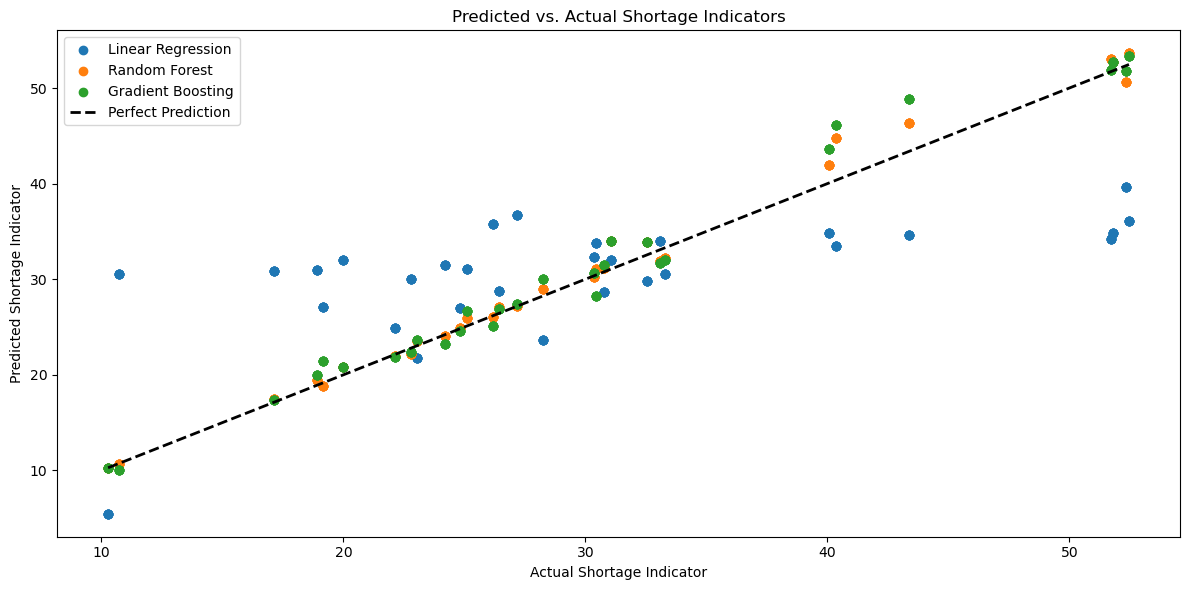

In [22]:
# Step 9: Plot Predicted vs. Actual Shortage Indicators
plt.figure(figsize=(12, 6))
for name, details in results.items():
    plt.scatter(y_test, details["Predictions"], label=name)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="Perfect Prediction")
plt.xlabel("Actual Shortage Indicator")
plt.ylabel("Predicted Shortage Indicator")
plt.title("Predicted vs. Actual Shortage Indicators")
plt.legend()
# Save and display the plot
plot_directory = "../plots"
os.makedirs(plot_directory, exist_ok=True)
plot_filename = "Predicted vs.Actual Shortage Indicators.png"
plt.tight_layout()
plt.savefig(f"{plot_filename}")
plt.show()

In [23]:
# Display evaluation results
evaluation_results

{'Linear Regression': {'CV RMSE': 11.199085810745709,
  'Test RMSE': 9.185911003447286,
  'Test MAE': 7.40682079375169},
 'Random Forest': {'Best Parameters': {'max_depth': None, 'n_estimators': 200},
  'CV RMSE': 4.359842366932261,
  'Test RMSE': 1.3622785904775134,
  'Test MAE': 0.9399680720505693},
 'Gradient Boosting': {'Best Parameters': {'learning_rate': 0.1,
   'max_depth': 3,
   'n_estimators': 200},
  'CV RMSE': 4.0320778870640215,
  'Test RMSE': 1.94473738522925,
  'Test MAE': 1.3382545545308835}}

### Shortage Indicator

`# Use a derived shortage indicator: ratio of cost-burdened households to total households (proxy: a18 / a1)`

`extended_df['shortage_indicator'] = extended_df['a18'] / (extended_df['a1'] + 1e-6)  # Avoid division by zero`

- a18: This represents the number of cost-burdened households, i.e., households that are paying more than a certain percentage of their income on housing costs.
- a1: This represents the total number of households in the metro area.

How the Shortage Indicator is Calculated:
The shortage indicator is defined as the ratio of cost-burdened households to total households. This gives a sense of the proportion of households facing affordability issues.

Why the Values Range from 10 to 50:

1. Cost-Burdened Households Relative to Total Households:
    - If the ratio of cost-burdened households (a18) to total households (a1) is relatively low (e.g., 10-20%), the shortage indicator will also be low, possibly around 10.
    - If a significant proportion of households are cost-burdened (e.g., 50% or more), the shortage indicator will be higher, and this can explain why you see values in the range of 10 to 50.
2. Scaling Factor (1e-6):
    - The small constant 1e-6 is added to avoid division by zero if there are any metro areas with zero total households. This helps prevent errors but doesn’t significantly affect the scale of the values.
3. Data Distribution:
    - The resulting shortage indicator might fall within the 10-50 range based on the distribution of cost-burdened households. For instance, metro areas with high housing costs relative to income (and hence more cost-burdened households) would have higher values, which naturally fall within this range.
  
The range of 10 to 50 on the y-axis and x-axis is the result of how the shortage indicator was defined, based on the ratio of cost-burdened households to total households. This scale is a measure of housing affordability stress, and higher values indicate higher shortage levels.

#### Model Interpretation

1. Models Comparison:
- Points closer to the dashed line ("Perfect Prediction") indicate more accurate predictions.
- In this case, the Random Forest and Gradient Boosting models perform better than Linear Regression, as their points cluster closer to the line.

2. Metrics Interpretation:
- Root Mean Squared Error (RMSE) = Measures the average magnitude of prediction errors, with larger errors penalized more due to squaring.
    - Lower RMSE indicates better performance.
        - Random Forest: 1.36 (best performance on the test set).
        - Gradient Boosting: 1.94 (close performance).
        - Linear Regression: 9.19 (least accurate).
- Mean Absolute Error (MAE):
    - Measures the average absolute prediction error, treating all errors equally.
    - Random Forest and Gradient Boosting also perform better here:
        - Random Forest: 0.94 (lowest error).
        - Gradient Boosting: 1.34.
        - Linear Regression: 7.40 (worst).
- Cross-Validation RMSE:
    - Evaluates model consistency across training splits:
    - Gradient Boosting has the lowest CV RMSE (4.03), followed closely by Random Forest (4.36).
    - Linear Regression has a high CV RMSE (11.20), indicating poorer generalization.

Conclusion:

- Best Model is Random Forest performs best overall with the lowest test RMSE and MAE.
- Gradient Boosting: Also performs well and might be preferred if interpretability or smaller datasets are a concern.
- Linear Regression: Performs poorly compared to the other models, likely due to its simplicity and inability to capture complex relationships.

To identify which Metropolitan Statistical Areas (MSAs) are at risk of affordable housing shortages:

Use Predictions:

Look at the predicted shortage indicator (y_pred) for each MSA in the test set (2025–2030).
- Set a threshold to classify MSAs at risk, such as:
- Top 20% of predicted shortage indicators.
- Shortage indicator above a predefined value (e.g., 30).

Rank MSAs:
- Rank MSAs based on their predicted shortage indicators for each year.
- Highlight MSAs with the highest risk for future years.

Summarize by Time Period:
- Summarize results by year to see trends in predicted shortages.

In [26]:
# Step 10: Identify High-Risk MSAs for Affordable Housing Shortages

# Add predictions back to the test dataset for analysis (e.g., Random Forest model)
rf_predictions = results["Random Forest"]["Predictions"]
test_df["predicted_shortage_indicator"] = rf_predictions

# Define a threshold for high-risk MSAs (e.g., top 20% of predictions)
threshold = np.percentile(rf_predictions, 80)  # Top 20% cutoff

# Identify high-risk MSAs
high_risk_msas = test_df[test_df["predicted_shortage_indicator"] >= threshold]

# Summarize by year and MSA
high_risk_summary = high_risk_msas.groupby(["year", "metro_area"])[
    "predicted_shortage_indicator"
].mean().reset_index()

# Sort by year and predicted shortage indicator
high_risk_summary = high_risk_summary.sort_values(
    by=["year", "predicted_shortage_indicator"], ascending=[True, False]
)

# Manually set the custom legend
custom_legend = [
    "Alexandria, VA", "Jersey City, NJ", "Sandy Springs, GA", 
    "Arlington, VA", "Naperville, IL", "Cambridge, MA"
]

C:\Users\deeps\AppData\Local\Temp\ipykernel_31556\3733302797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_shortage_indicator"] = rf_predictions


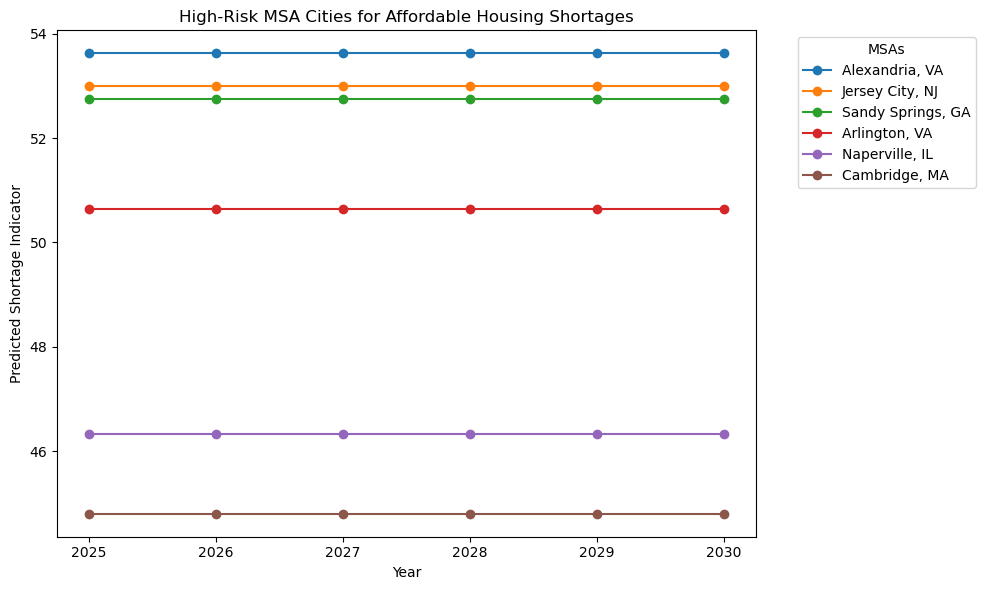

'Plot saved as: ./plots/High_Risk_MSA_Cities_for_Affordable_Housing_Shortages.png'

In [27]:
# Step 11: Plot High-Risk MSAs for Affordable Housing Shortages (2025–2030)
plt.figure(figsize=(10, 6))

for i, metro_area in enumerate(custom_legend):
    msa_data = high_risk_summary[high_risk_summary["metro_area"].str.contains(metro_area.split(',')[0])]
    plt.plot(
        msa_data["year"], 
        msa_data["predicted_shortage_indicator"], 
        marker='o', 
        label=custom_legend[i]  # Use the custom legend names
    )

# Title and labels
plt.title("High-Risk MSA Cities for Affordable Housing Shortages")
plt.xlabel("Year")
plt.ylabel("Predicted Shortage Indicator")

# Custom legend
plt.legend(title="MSAs", bbox_to_anchor=(1.05, 1), loc="upper left")

# Remove gridlines
plt.grid(False)

# Save and display the plot
plot_directory = "../plots"
os.makedirs(plot_directory, exist_ok=True)
plot_filename = "High_Risk_MSA_Cities_for_Affordable_Housing_Shortages.png"
plt.tight_layout()
plt.savefig(f"{plot_filename}")

# Show the plot
plt.show()

# Output the file path for confirmation
f"Plot saved as: {plot_directory}/{plot_filename}"

### How to Read the Plot

1. Y-Axis: Predicted Shortage Indicator

- The predicted shortage indicator represents a quantitative estimate of the level of affordable housing shortages in a given metro area (MSA) for the forecast years 2025–2030.
- A higher value on the Y-axis indicates a greater predicted shortage, meaning more significant affordable housing challenges.
- If the indicator is based on factors like the number of cost-burdened households, higher values could reflect a combination of:
    - Higher housing costs relative to income.
    - Increased demand and limited supply of affordable housing.

2. X-Axis: Year (2025–2030)

- The x-axis represents the forecast years from 2025 to 2030.
- The plot tracks predicted changes in the affordable housing shortage indicator over time for each MSA, based on historical data and extrapolated trends.

3. Flat or Rising Lines:

- If a metro area (MSA) has a relatively flat line, this suggests that the predicted shortage remains constant over time.
- Rising lines indicate that the shortage is expected to increase as time progresses (i.e., the affordable housing situation worsens).

4. Comparing MSAs:
- By comparing the height and slope of the lines for different MSAs, you can identify which areas are predicted to experience the most significant increases in shortage over the forecast period.
- For instance, if Arlington, VA shows a sharp rise in predicted shortage indicators, it suggests that the area might face more severe challenges in housing affordability compared to, say, Jersey City, NJ, if it has a flatter trend.

Conclusion:
- Higher Y-axis values signal more severe shortages.
- Upward trends over the years suggest that the affordable housing situation is likely to worsen in those cities.